In [1]:
%pip install xgboost
%pip install ccxt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import skew
from sklearn.decomposition import PCA
from scipy.linalg import norm
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import ccxt
from datetime import datetime, timedelta
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import statsmodels.api as sm
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [6]:
df_sentiments = pd.read_csv("sentiment_raw2.csv", index_col=0)

In [7]:
import pandas as pd
import numpy as np
"""
    Analyze sentiment data at minute-level granularity.
    
    Parameters:
    df_sentiments (pd.DataFrame): DataFrame containing sentiment data with columns:
        post_time, ticker, relevance, sentiment, confidence, prob_pos, prob_ntr, prob_neg,
        reddit_topic, topicweight, source, sourceweight, author, novelty, comment_count
        
    Returns:
    tuple: (ticker_sentiment_minute, market_sentiment_minute) DataFrames with minute-level aggregations
"""

# Select relevant columns
df_sentiments = df_sentiments.loc[:, ['post_time', 'ticker',
       'relevance', 'sentiment', 'confidence', 'prob_pos', 'prob_ntr',
       'prob_neg', 'reddit_topic', 'topicweight', 'source',
       'sourceweight', 'author', 'novelty', 'comment_count']]
df_sentiments['post_time'] = pd.to_datetime(df_sentiments['post_time'], format="%Y-%m-%d %H:%M:%S")

# Filter data between 00:00:00 and 23:45:00
df_sentiments = df_sentiments[
    (df_sentiments['post_time'].dt.strftime('%H:%M:%S') >= "00:00:00") &
    (df_sentiments['post_time'].dt.strftime('%H:%M:%S') <= "23:45:00")
]

# Round timestamps to the nearest minute
df_sentiments['minute'] = df_sentiments['post_time'].dt.floor('min')

# Sentiment by ticker and minute
ticker_sentiment = df_sentiments.groupby(['minute', 'ticker']).agg(
    obs_count=('prob_pos', 'size'),
    mean_pos=('prob_pos', 'mean'),
    mean_ntr=('prob_ntr', 'mean'),
    mean_neg=('prob_neg', 'mean'),
    # Uncomment and adjust if you want weighted calculations
    # weighted_pos=('confidence', lambda x: np.sum(df_sentiments.loc[x.index, 'prob_pos'] * x) / x.sum()),
    # weighted_ntr=('confidence', lambda x: np.sum(df_sentiments.loc[x.index, 'prob_ntr'] * x) / x.sum()),
    # weighted_neg=('confidence', lambda x: np.sum(df_sentiments.loc[x.index, 'prob_neg'] * x) / x.sum())
).reset_index()

# Market-wide sentiment by minute
market_sentiment = df_sentiments.groupby('minute').agg(
    market_mean_pos=('prob_pos', 'mean'),
    market_mean_ntr=('prob_ntr', 'mean'),
    market_mean_neg=('prob_neg', 'mean'),
    # Uncomment and adjust if you want weighted calculations
    # market_weighted_pos=('confidence', lambda x: np.sum(df_sentiments.loc[x.index, 'prob_pos'] * x) / x.sum()),
    # market_weighted_ntr=('confidence', lambda x: np.sum(df_sentiments.loc[x.index, 'prob_ntr'] * x) / x.sum()),
    # market_weighted_neg=('confidence', lambda x: np.sum(df_sentiments.loc[x.index, 'prob_neg'] * x) / x.sum())
).reset_index()

# Drop rows where no sentiment was observed
ticker_sentiment = ticker_sentiment.dropna(subset=['obs_count'])

# Filter out tickers with insufficient observations (adjusted for minute-level data)
# You may want to adjust the threshold from 2000 based on your minute-level requirements
minutes_threshold = 2000  # Adjust this value based on your needs
ticker_counts = ticker_sentiment.groupby("ticker")["obs_count"].count()
tickers_over_threshold = ticker_counts[ticker_counts > minutes_threshold].index
ticker_sentiment = ticker_sentiment[ticker_sentiment['ticker'].isin(tickers_over_threshold)]

In [15]:
import pandas as pd
import numpy as np

# Read and process price data
df_prices = pd.read_csv("prices_raw.csv", low_memory=False)
df_prices = df_prices.loc[:,['sym', 'close', 'high', 'low', 'open', 'volumefrom', 'volumeto', '@timestamp']]
df_prices['sym'] = df_prices['sym'].str.replace("USD$", "", regex=True)
df_prices['date'] = pd.to_datetime(df_prices['@timestamp'], utc=True, format='mixed').dt.date
df_prices.rename(columns={"sym":"ticker"}, inplace=True)

# Calculate daily returns
df_prices = df_prices.sort_values(['ticker', 'date'])
df_prices['next_day_ret'] = df_prices.groupby('ticker')['close'].pct_change().shift(-1)

# Process sentiment data
ticker_sentiment['minute'] = pd.to_datetime(ticker_sentiment['minute'])
ticker_sentiment['date'] = ticker_sentiment['minute'].dt.date
ticker_sentiment['hour'] = ticker_sentiment['minute'].dt.hour

# Create time-based sentiment features
intraday_sentiment = ticker_sentiment.groupby(['date', 'ticker', 'hour']).agg({
    'obs_count': 'sum',
    'mean_pos': 'mean',
    'mean_neg': 'mean',
    'mean_ntr': 'mean'
}).reset_index()

# Calculate sentiment momentum
intraday_sentiment['sentiment_momentum'] = (
    intraday_sentiment.groupby(['ticker', 'date'])['mean_pos']
    .diff()
    .fillna(0)
)

# Create various sentiment aggregations
daily_sentiment_stats = intraday_sentiment.groupby(['date', 'ticker']).agg({
    'mean_pos': ['mean', 'std', 'min', 'max'],
    'mean_neg': ['mean', 'std', 'min', 'max'],
    'sentiment_momentum': ['mean', 'std'],
    'obs_count': ['sum']
}).reset_index()

# Flatten column names
daily_sentiment_stats.columns = [
    f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
    for col in daily_sentiment_stats.columns
]

# Merge with price data
df_analysis = pd.merge(
    df_prices[['date', 'ticker', 'close', 'next_day_ret']],
    daily_sentiment_stats,
    on=['date', 'ticker'],
    how='inner'
)

# Print column names to verify
print("Available columns in df_analysis:")
print(df_analysis.columns.tolist())

# Calculate correlations for each ticker
correlations = {}
for ticker in df_analysis['ticker'].unique():
    ticker_data = df_analysis[df_analysis['ticker'] == ticker]
    
    if len(ticker_data) > 50:  # Minimum sample size
        corr = {
            'pos_mean_corr': ticker_data['mean_pos_mean'].corr(ticker_data['next_day_ret']),
            'pos_std_corr': ticker_data['mean_pos_std'].corr(ticker_data['next_day_ret']),
            'momentum_corr': ticker_data['sentiment_momentum_mean'].corr(ticker_data['next_day_ret']),
            'obs_count_corr': ticker_data['obs_count_sum'].corr(ticker_data['next_day_ret'])  # Fixed column name
        }
        correlations[ticker] = corr

# Convert correlations to DataFrame
corr_df = pd.DataFrame(correlations).T

# Basic statistics about the dataset
print("\nDataset Statistics:")
print(f"Number of unique tokens: {len(df_analysis['ticker'].unique())}")
print(f"Date range: {df_analysis['date'].min()} to {df_analysis['date'].max()}")

print("\nCorrelation Statistics:")
print(corr_df.describe())

# Find most predictive tokens
print("\nTop 5 tokens by positive sentiment correlation:")
print(corr_df.sort_values('pos_mean_corr', ascending=False).head())

print("\nTop 5 tokens by sentiment momentum correlation:")
print(corr_df.sort_values('momentum_corr', ascending=False).head())

# Analyze intraday patterns
hourly_stats = intraday_sentiment.groupby('hour').agg({
    'mean_pos': ['mean', 'std'],
    'obs_count': 'mean'
}).round(3)

print("\nIntraday Sentiment Patterns:")
print(hourly_stats)

Available columns in df_analysis:
['date', 'ticker', 'close', 'next_day_ret', 'mean_pos_mean', 'mean_pos_std', 'mean_pos_min', 'mean_pos_max', 'mean_neg_mean', 'mean_neg_std', 'mean_neg_min', 'mean_neg_max', 'sentiment_momentum_mean', 'sentiment_momentum_std', 'obs_count_sum']


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2842: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]



Dataset Statistics:
Number of unique tokens: 231
Date range: 2018-01-01 to 2024-08-31

Correlation Statistics:
       pos_mean_corr  pos_std_corr  momentum_corr  obs_count_corr
count     217.000000    221.000000     217.000000      217.000000
mean        0.000585     -0.003725      -0.005365       -0.003211
std         0.045804      0.069184       0.059604        0.053662
min        -0.259263     -0.389402      -0.394531       -0.277449
25%        -0.020345     -0.025732      -0.024901       -0.029396
50%         0.002462     -0.002479      -0.004835       -0.004976
75%         0.024152      0.024811       0.013280        0.024660
max         0.174564      0.299202       0.320845        0.282664

Top 5 tokens by positive sentiment correlation:
     pos_mean_corr  pos_std_corr  momentum_corr  obs_count_corr
ETN       0.174564      0.275753      -0.394531        0.015971
ORN       0.121111     -0.148451       0.011325       -0.029396
MIR       0.117975     -0.085208      -0.064790      

1) Overall Sentiment-Price Relationship:

The correlations between sentiment and next-day returns are generally weak (mean pos_mean_corr = 0.00059)
There's high variability in these relationships (std = 0.046)
The correlations are roughly symmetrically distributed around zero (median = 0.002462)


2) Notable Tokens:

ETN shows the strongest positive sentiment correlation (0.175)
However, ETN also shows conflicting signals with a strong negative momentum correlation (-0.395)
ELA shows the strongest sentiment momentum correlation (0.321)
Most tokens show very modest correlations, suggesting limited predictive power


3) Intraday Patterns:

Trading activity (obs_count) peaks during 14:00-16:00 UTC (about 6 observations per minute)
Lowest activity is during 23:00-04:00 UTC (about 4.5-4.7 observations per minute)
Sentiment positivity is relatively stable throughout the day (0.458-0.471)
Slightly higher positive sentiment during: 14:00 UTC (0.471) and 08:00 UTC (0.470)
Sentiment volatility (std) is higher during night hours (0.267-0.270) compared to day hours (0.262-0.265)

4) Risk Considerations:

High standard deviations in correlations suggest these relationships are not stable
Even the strongest correlations (0.17-0.32) explain only a small portion of price movements
Some tokens show opposing correlations between different sentiment metrics

In [18]:
import pandas as pd
import numpy as np

# Define tokens of interest
TOKENS_OF_INTEREST = ['BTC', 'ETH', 'DOGE']

# Read and process price data
df_prices = pd.read_csv("prices_raw.csv", low_memory=False)
df_prices = df_prices.loc[:,['sym', 'close', 'high', 'low', 'open', 'volumefrom', 'volumeto', '@timestamp']]
df_prices['sym'] = df_prices['sym'].str.replace("USD$", "", regex=True)
df_prices['date'] = pd.to_datetime(df_prices['@timestamp'], utc=True, format='mixed').dt.date
df_prices.rename(columns={"sym":"ticker"}, inplace=True)

# Filter for tokens of interest
df_prices = df_prices[df_prices['ticker'].isin(TOKENS_OF_INTEREST)]

# Calculate daily returns and volatility
df_prices = df_prices.sort_values(['ticker', 'date'])
df_prices['daily_ret'] = df_prices.groupby('ticker')['close'].pct_change()
df_prices['next_day_ret'] = df_prices['daily_ret'].shift(-1)
df_prices['volatility'] = df_prices.groupby('ticker')['daily_ret'].rolling(window=5).std().reset_index(0, drop=True)

# Process sentiment data for specific tokens
ticker_sentiment = ticker_sentiment[ticker_sentiment['ticker'].isin(TOKENS_OF_INTEREST)].copy()
ticker_sentiment['minute'] = pd.to_datetime(ticker_sentiment['minute'])
ticker_sentiment['date'] = ticker_sentiment['minute'].dt.date
ticker_sentiment['hour'] = ticker_sentiment['minute'].dt.hour

# Create daily sentiment aggregations with more granular statistics
daily_sentiment = ticker_sentiment.groupby(['date', 'ticker']).agg({
    'mean_pos': ['mean', 'std', 'min', 'max', 'count'],
    'mean_neg': ['mean', 'std', 'min', 'max'],
    'mean_ntr': ['mean', 'std', 'min', 'max'],
    'obs_count': ['sum']
}).reset_index()

# Flatten column names
daily_sentiment.columns = [
    f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
    for col in daily_sentiment.columns
]

# Merge price and sentiment data
df_analysis = pd.merge(
    df_prices[['date', 'ticker', 'close', 'daily_ret', 'next_day_ret', 'volatility']],
    daily_sentiment,
    on=['date', 'ticker'],
    how='inner'
)

# Calculate sentiment changes
df_analysis['sentiment_change'] = df_analysis.groupby('ticker')['mean_pos_mean'].diff()

# Analysis results storage
results = {}

for ticker in TOKENS_OF_INTEREST:
    token_data = df_analysis[df_analysis['ticker'] == ticker].copy()
    
    # Basic correlations
    correlations = {
        'next_day_return': token_data['mean_pos_mean'].corr(token_data['next_day_ret']),
        'same_day_return': token_data['mean_pos_mean'].corr(token_data['daily_ret']),
        'sentiment_change_return': token_data['sentiment_change'].corr(token_data['daily_ret']),
        'volatility': token_data['mean_pos_std'].corr(token_data['volatility'])
    }
    
    # Sentiment impact analysis
    high_sentiment = token_data[token_data['mean_pos_mean'] > token_data['mean_pos_mean'].mean()]
    low_sentiment = token_data[token_data['mean_pos_mean'] <= token_data['mean_pos_mean'].mean()]
    
    sentiment_impact = {
        'high_sentiment_next_return': high_sentiment['next_day_ret'].mean(),
        'low_sentiment_next_return': low_sentiment['next_day_ret'].mean(),
        'high_sentiment_volatility': high_sentiment['volatility'].mean(),
        'low_sentiment_volatility': low_sentiment['volatility'].mean(),
    }
    
    # Store results
    results[ticker] = {
        'correlations': correlations,
        'sentiment_impact': sentiment_impact,
        'data_points': len(token_data),
        'date_range': (token_data['date'].min(), token_data['date'].max())
    }

# Print results
for ticker in TOKENS_OF_INTEREST:
    print(f"\n{'-'*50}")
    print(f"{ticker} Analysis:")
    print(f"Date Range: {results[ticker]['date_range'][0]} to {results[ticker]['date_range'][1]}")
    print(f"Number of observations: {results[ticker]['data_points']}")
    
    print("\nCorrelations:")
    for metric, value in results[ticker]['correlations'].items():
        print(f"{metric}: {value:.4f}")
    
    print("\nSentiment Impact:")
    for metric, value in results[ticker]['sentiment_impact'].items():
        print(f"{metric}: {value:.4f}")
    
    # Get market conditions during extreme sentiment
    token_data = df_analysis[df_analysis['ticker'] == ticker]
    extreme_positive = token_data[token_data['mean_pos_mean'] > token_data['mean_pos_mean'].quantile(0.9)]
    extreme_negative = token_data[token_data['mean_pos_mean'] < token_data['mean_pos_mean'].quantile(0.1)]
    
    print(f"\nExtreme Sentiment Analysis:")
    print(f"Average next-day return after top 10% positive sentiment: {extreme_positive['next_day_ret'].mean():.4f}")
    print(f"Average next-day return after bottom 10% positive sentiment: {extreme_negative['next_day_ret'].mean():.4f}")

# Optional: Save detailed results for further analysis
df_analysis.to_csv(f"sentiment_price_analysis_{pd.Timestamp.now().strftime('%Y%m%d')}.csv", index=False)


--------------------------------------------------
BTC Analysis:
Date Range: 2018-01-01 to 2024-08-31
Number of observations: 2435

Correlations:
next_day_return: 0.0143
same_day_return: 0.2599
sentiment_change_return: 0.2456
volatility: -0.3811

Sentiment Impact:
high_sentiment_next_return: 0.0023
low_sentiment_next_return: 0.0002
high_sentiment_volatility: 0.0299
low_sentiment_volatility: 0.0317

Extreme Sentiment Analysis:
Average next-day return after top 10% positive sentiment: 0.0058
Average next-day return after bottom 10% positive sentiment: 0.0024

--------------------------------------------------
ETH Analysis:
Date Range: 2018-01-01 to 2024-08-31
Number of observations: 2435

Correlations:
next_day_return: 0.0208
same_day_return: 0.2036
sentiment_change_return: 0.1778
volatility: -0.2059

Sentiment Impact:
high_sentiment_next_return: 0.0017
low_sentiment_next_return: 0.0015
high_sentiment_volatility: 0.0396
low_sentiment_volatility: 0.0400

Extreme Sentiment Analysis:
Avera

1) Same-Day Impact is Strongest:

BTC and ETH show significant same-day correlations with sentiment (0.2599 and 0.2036 respectively)
This suggests sentiment has an immediate impact rather than predictive power
DOGE is an outlier with minimal same-day correlation (0.0002)


2) Sentiment Changes Matter:


BTC and ETH show strong correlations with sentiment changes (0.2456 and 0.1778)
This indicates that changes in sentiment, rather than absolute levels, drive price movements
DOGE shows a slight negative correlation (-0.0060), behaving differently from BTC/ETH


3) Volatility Relationship:


Strong negative correlation with volatility for BTC (-0.3811) and ETH (-0.2059)
This suggests higher sentiment periods are associated with lower volatility
DOGE shows almost no volatility correlation (0.0052), again diverging from BTC/ETH

4) Predictive Value:


Next-day return correlations are very weak (0.0143 for BTC, 0.0208 for ETH, 0.0111 for DOGE)
However, extreme sentiment does have some predictive power:

High sentiment periods show better next-day returns than low sentiment periods
Most pronounced for BTC (0.0058 vs 0.0024) and ETH (0.0071 vs 0.0008)

5) Asset-Specific Patterns:


BTC and ETH show similar patterns in sentiment-price relationships
DOGE behaves quite differently, with much weaker correlations overall
This suggests sentiment analysis might be more reliable for major cryptocurrencies

6) Trading Implications:

Focus on same-day movements rather than next-day predictions
Pay attention to sentiment changes rather than absolute levels
Use sentiment as a volatility indicator for BTC and ETH
Consider sentiment extremes for potential trading signals
Be cautious with DOGE as it shows different sentiment-price dynamics


Data Loading and Preparation: Loads price and sentiment data, filtering for BTC, ETH and DOGE.

Daily Aggregation:

Groups sentiment data by date and ticker, calculating the mean, standard deviation, min, max, and count of positive, negative and neutral sentiment scores, as well as the sum of observations (obs_count).

Data Merging: Merges the price and daily-aggregated sentiment data into a single df_analysis DataFrame.

Sentiment Change: Calculates the sentiment change by taking the difference in the mean_pos_mean between two days.

Correlation Analysis:

Calculates the correlation between the average daily positive sentiment and the next day returns, the same day returns, and the sentiment change and the same day returns. It also calculates the correlation of volatility of positive sentiment with price volatility.

Sentiment Impact Analysis: Splits the data based on the average daily sentiment, calculates the mean next day return and average volatility when there are high and low levels of daily positive sentiment.

Extreme Sentiment Analysis: Calculates the average next day returns when sentiment is in the top and bottom 10% of the data.

Analysis of Results

Here's how to interpret the results for each cryptocurrency:

1. BTC Analysis

Date Range: The data covers the entire period from 2018-01-01 to 2024-08-31

Observations: There are 2435 days of observation for BTC in this data.

Correlations

next_day_return: The correlation between average daily positive sentiment and next-day returns is very weak (0.0143). This is not very useful for prediction.

same_day_return: There is a moderate correlation between daily sentiment and same-day returns at 0.2599, suggesting that sentiment accumulates and has a concurrent impact.

sentiment_change_return: Similar to same-day return, sentiment change has a moderate correlation with current day returns at 0.245

volatility: We see a negative correlation between standard deviation of sentiment and price volatility, indicating that price volatility tends to be lower when there is a higher standard deviation in sentiment

Sentiment Impact

high_sentiment_next_return: On average, when the daily positive sentiment is higher than average, the next-day return is slightly positive (0.0023).

low_sentiment_next_return: On average, when the daily positive sentiment is lower than average, the next-day return is negligibly small (0.0002).

high_sentiment_volatility and low_sentiment_volatility: As before, there is a small difference in volatility based on sentiment.

Extreme Sentiment Analysis:

Average next-day return after top 10% positive sentiment: The next day return is higher than normal (0.0058) when daily sentiment is high.

Average next-day return after bottom 10% positive sentiment: The next day return is positive (0.0024), but lower than if sentiment were high.

2. ETH Analysis

Date Range: The data covers the entire period from 2018-01-01 to 2024-08-31

Observations: There are 2435 days of observation for ETH in this data

Correlations

next_day_return: The correlation between average daily positive sentiment and next-day returns is also weak (0.0208)

same_day_return: There is a moderate correlation between daily sentiment and same-day returns (0.2036)

sentiment_change_return: There is a moderate correlation between daily sentiment change and current day returns (0.1778)

volatility: We see a negative correlation between standard deviation of sentiment and price volatility, indicating that price volatility tends to be lower when there is a higher standard deviation in sentiment

Sentiment Impact

high_sentiment_next_return: The next day return is positive, but not higher than average (0.0017), when the daily positive sentiment is higher than average

low_sentiment_next_return: When daily positive sentiment is lower than average, there is negligibly little difference in returns (0.0015)

high_sentiment_volatility and low_sentiment_volatility: There is no significant difference in volatility.

Extreme Sentiment Analysis:

Average next-day return after top 10% positive sentiment: When the daily positive sentiment is very high, the average next day return is somewhat positive (0.0071).

Average next-day return after bottom 10% positive sentiment: The next day return is closer to zero when sentiment is low (0.0008)

3. DOGE Analysis

Date Range: The data covers the entire period from 2018-01-01 to 2024-08-31

Observations: There are 2423 days of observation for DOGE in this data

Correlations

next_day_return: Very weak correlations between daily sentiment and the next day's price (0.0111)

same_day_return: Negligible correlations between daily sentiment and daily price (0.0002).

sentiment_change_return: Negligible (and negative) correlation between daily sentiment and daily return (-0.006).

volatility: A negligible correlation between standard deviation of sentiment and price volatility (0.0052)

Sentiment Impact

high_sentiment_next_return: When daily sentiment is higher than average, the next day return is negligibly positive (0.0077).

low_sentiment_next_return: When daily sentiment is lower than average, the next day return is also near zero (0.0006).

high_sentiment_volatility and low_sentiment_volatility: The average daily price volatility is slightly higher when sentiment is low.

Extreme Sentiment Analysis:

Average next-day return after top 10% positive sentiment: When daily sentiment is very high the average next day return is close to 0 (0.0014)

Average next-day return after bottom 10% positive sentiment: When daily sentiment is very low, the next day return is also close to 0 (-0.0016)

How is this better?

Clearer Summary Metrics: This analysis has clearly separated the correlation analysis, sentiment impact and the effect of extreme sentiment which makes it much easier to understand the effects.

Direct Price Impact: It tests the direct impact of sentiment by analysing conditional returns and looking at extreme sentiment events.

More Refined Metrics: Includes more informative metrics, such as sentiment change, and correlations with volatility, which are not in the previous heatmap data, but which we saw might be valuable in strategy development.

How is this worse?

No Time Lags: The correlation analysis doesn't test the correlation at different time lags, so we lose the information regarding whether sentiment leads price or not

Limited Cross-Timeframe Correlations: It does not look at how daily sentiment data impacts shorter time scales and vice-versa.

Over Simplification: By calculating all metrics as an average, it hides the more nuanced relationships that may be present across the dataset.

Overall Assessment:

This analysis provides a more refined picture of the direct impact of sentiment levels on the same day and next day returns. In this analysis, we are now directly testing whether sentiment has any impact on the price action.
The key insight from this analysis was the clear correlation between daily sentiment and concurrent price movements and that, for ETH and BTC, the daily sentiment can also predict future returns.
However, the main weakness of this code is that it no longer tests the correlation with different time lags. It also relies on daily aggregated sentiment data, which is something we wanted to move away from, and it ignores the insights from the hourly time scale.



In [21]:
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime, timedelta
from tqdm import tqdm  # For progress tracking

def get_historical_minute_data(symbol, start_date, end_date):
    """
    Fetch historical minute-level data from Binance
    
    Parameters:
    - symbol: trading pair (e.g., 'BTCUSDT')
    - start_date: start date as string 'YYYY-MM-DD'
    - end_date: end date as string 'YYYY-MM-DD'
    """
    url = 'https://api.binance.com/api/v3/klines'
    
    # Convert dates to timestamps in milliseconds
    start_ts = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_ts = int(pd.Timestamp(end_date).timestamp() * 1000)
    
    all_data = []
    current_ts = start_ts
    
    # Calculate total number of days for progress bar
    total_days = (pd.Timestamp(end_date) - pd.Timestamp(start_date)).days
    
    with tqdm(total=total_days, desc=f"Fetching {symbol} data") as pbar:
        while current_ts < end_ts:
            # Parameters for API call
            params = {
                'symbol': symbol,
                'interval': '1m',
                'startTime': current_ts,
                'limit': 1000  # Maximum allowed by Binance
            }
            
            try:
                response = requests.get(url, params=params)
                response.raise_for_status()  # Raise exception for bad status codes
                data = response.json()
                
                if not data:
                    break
                    
                all_data.extend(data)
                
                # Update timestamp for next iteration
                current_ts = data[-1][0] + 60000  # Add one minute in milliseconds
                
                # Update progress bar (approximately)
                pbar.update(1)
                
                # Respect rate limits
                time.sleep(0.1)  # 10 requests per second should be safe
                
            except requests.exceptions.RequestException as e:
                print(f"Error fetching data for {symbol}: {e}")
                time.sleep(5)  # Wait longer on error
                continue
    
    # Convert to DataFrame
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 
        'volume', 'close_time', 'quote_volume', 'trades',
        'taker_buy_volume', 'taker_buy_quote_volume', 'ignore'
    ])
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['minute'] = df['timestamp'].dt.floor('min')
    
    # Convert price and volume columns to float
    for col in ['open', 'high', 'low', 'close', 'volume', 'quote_volume']:
        df[col] = df[col].astype(float)
    
    # Calculate returns
    df['ret_1m'] = df['close'].pct_change()
    df['log_ret_1m'] = np.log(df['close']/df['close'].shift(1))
    
    return df

def analyze_price_sentiment_relationship(price_df, sentiment_df, symbol):
    """
    Analyze the relationship between price movements and sentiment
    
    Parameters:
    - price_df: DataFrame with minute-level price data
    - sentiment_df: DataFrame with sentiment data
    - symbol: crypto symbol (e.g., 'BTC')
    """
    # Filter sentiment data for the symbol
    symbol_sentiment = sentiment_df[sentiment_df['ticker'] == symbol].copy()
    
    # Merge price and sentiment data
    merged_df = pd.merge(
        price_df,
        symbol_sentiment,
        on='minute',
        how='inner'
    )
    
    # Calculate correlations at different lags
    correlations = {}
    for lag in range(-5, 6):  # -5 to +5 minutes
        if lag < 0:
            corr = merged_df['mean_pos'].corr(merged_df['ret_1m'].shift(abs(lag)))
            correlations[f'sentiment_leads_{abs(lag)}m'] = corr
        elif lag > 0:
            corr = merged_df['mean_pos'].corr(merged_df['ret_1m'].shift(-lag))
            correlations[f'price_leads_{lag}m'] = corr
        else:
            corr = merged_df['mean_pos'].corr(merged_df['ret_1m'])
            correlations['concurrent'] = corr
    
    return merged_df, correlations

# Main execution
start_date = '2024-01-01'
end_date = '2024-08-31'
symbols = ['BTCUSDT', 'ETHUSDT', 'DOGEUSDT']

# Store results
price_data = {}
analysis_results = {}

# Fetch price data for each symbol
for symbol in symbols:
    print(f"\nProcessing {symbol}...")
    
    # Get price data
    price_data[symbol] = get_historical_minute_data(symbol, start_date, end_date)
    
    # Analyze relationship with sentiment
    base_symbol = symbol.replace('USDT', '')
    merged_data, correlations = analyze_price_sentiment_relationship(
        price_data[symbol], 
        ticker_sentiment,  # Your existing sentiment data
        base_symbol
    )
    
    analysis_results[symbol] = {
        'correlations': correlations,
        'merged_data': merged_data
    }
    
    print(f"\nCorrelations for {symbol}:")
    for k, v in correlations.items():
        print(f"{k}: {v:.4f}")
    
    # Basic statistics
    print(f"\nBasic statistics for {symbol}:")
    print(f"Number of matched observations: {len(merged_data)}")
    print(f"Average sentiment: {merged_data['mean_pos'].mean():.4f}")
    print(f"Sentiment std: {merged_data['mean_pos'].std():.4f}")
    print(f"Average 1-min return: {merged_data['ret_1m'].mean():.6f}")
    print(f"Return std: {merged_data['ret_1m'].std():.6f}")


Processing BTCUSDT...


Fetching BTCUSDT data: 350it [12:18,  2.11s/it]                         



Correlations for BTCUSDT:
sentiment_leads_5m: 0.0031
sentiment_leads_4m: 0.0039
sentiment_leads_3m: -0.0001
sentiment_leads_2m: 0.0038
sentiment_leads_1m: 0.0056
concurrent: 0.0012
price_leads_1m: -0.0023
price_leads_2m: 0.0019
price_leads_3m: 0.0005
price_leads_4m: -0.0002
price_leads_5m: 0.0051

Basic statistics for BTCUSDT:
Number of matched observations: 209831
Average sentiment: 0.4225
Sentiment std: 0.2577
Average 1-min return: 0.000000
Return std: 0.000843

Processing ETHUSDT...


Fetching ETHUSDT data: 350it [12:24,  2.13s/it]                         



Correlations for ETHUSDT:
sentiment_leads_5m: -0.0011
sentiment_leads_4m: -0.0017
sentiment_leads_3m: -0.0011
sentiment_leads_2m: 0.0007
sentiment_leads_1m: -0.0017
concurrent: -0.0010
price_leads_1m: 0.0032
price_leads_2m: -0.0037
price_leads_3m: -0.0002
price_leads_4m: -0.0003
price_leads_5m: -0.0043

Basic statistics for ETHUSDT:
Number of matched observations: 110301
Average sentiment: 0.4440
Sentiment std: 0.2975
Average 1-min return: 0.000005
Return std: 0.001043

Processing DOGEUSDT...


Fetching DOGEUSDT data: 350it [12:06,  2.07s/it]                         



Correlations for DOGEUSDT:
sentiment_leads_5m: -0.0313
sentiment_leads_4m: -0.0234
sentiment_leads_3m: 0.0210
sentiment_leads_2m: 0.0134
sentiment_leads_1m: -0.0493
concurrent: -0.0142
price_leads_1m: 0.0231
price_leads_2m: -0.0090
price_leads_3m: -0.0213
price_leads_4m: 0.0245
price_leads_5m: -0.0163

Basic statistics for DOGEUSDT:
Number of matched observations: 3404
Average sentiment: 0.4870
Sentiment std: 0.3143
Average 1-min return: 0.000030
Return std: 0.001979


### Comparing the minute-level and daily analyses reveals some interesting insights:

1. Correlation Strength:


- Daily data shows much stronger correlations than minute data
- BTC daily same-day correlation: 0.2599
- BTC minute-level correlations: all below 0.01 (highest is 0.0056 for 1-minute lead)
- Similar pattern for ETH and DOGE


2. Key Findings:

A) Loss of Signal Strength:

The strong daily correlations (0.2599 for BTC, 0.2036 for ETH) completely disappear at minute level
This suggests sentiment's impact on price is more of a gradual, cumulative effect rather than immediate

B) Lead-Lag Relationships:

Daily data shows clear relationships (sentiment changes correlate with same-day returns)
Minute data shows *very weak lead-lag effects (correlations < 0.05 across all timeframes)
No significant improvement in predictive power at shorter intervals

C) Asset-Specific Patterns:

BTC and ETH show similar patterns in both timeframes
DOGE shows more volatile correlations at minute level but weaker overall relationships


3. Conclusions:

The minute-level analysis reveals that sentiment's impact on price is not immediate
Trading strategies should focus on daily timeframes where correlations are stronger
Minute-level data might be more useful for risk management than signal generation

In [24]:
def analyze_sentiment_impact(merged_data, params):
    """
    Analyze sentiment impact on price movements with multiple metrics
    """
    # Make sure we're working with a copy and the index is datetime
    data = merged_data.copy()
    data['timestamp'] = pd.to_datetime(data['minute'])
    data.set_index('timestamp', inplace=True)
    
    # 1. Analyze returns conditional on sentiment levels
    sentiment_quantiles = pd.qcut(data['mean_pos'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    data['sentiment_level'] = sentiment_quantiles
    
    # Calculate returns by sentiment level
    returns_by_sentiment = data.groupby('sentiment_level').agg({
        'ret_1m': ['mean', 'std', 'count'],
        'volume': 'mean'
    })
    
    # 2. Analyze significant sentiment changes
    data['sentiment_change'] = data['mean_pos'].diff()
    significant_changes = data[abs(data['sentiment_change']) > params.get('sentiment_threshold', 0.1)]
    
    # 3. Calculate price impact around significant sentiment changes
    event_returns = []
    window = params.get('window', 5)  # minutes
    
    for event_time in significant_changes.index:
        try:
            pre_window = data.loc[event_time - pd.Timedelta(minutes=window):event_time]
            post_window = data.loc[event_time:event_time + pd.Timedelta(minutes=window)]
            
            if not pre_window.empty and not post_window.empty:
                event_returns.append({
                    'event_time': event_time,
                    'sentiment_change': significant_changes.loc[event_time, 'sentiment_change'],
                    'pre_return': pre_window['ret_1m'].sum(),
                    'post_return': post_window['ret_1m'].sum(),
                    'pre_vol': pre_window['volume'].mean(),
                    'post_vol': post_window['volume'].mean(),
                    'pre_volatility': pre_window['ret_1m'].std(),
                    'post_volatility': post_window['ret_1m'].std(),
                    'sentiment_level': significant_changes.loc[event_time, 'sentiment_level']
                })
        except (KeyError, TypeError) as e:
            continue
    
    event_df = pd.DataFrame(event_returns)
    
    # 4. Volume-weighted impact analysis
    data['volume_weighted_return'] = data['ret_1m'] * data['volume']
    vw_impact = data.groupby(sentiment_quantiles).agg({
        'volume_weighted_return': ['mean', 'std'],
        'volume': 'sum',
        'ret_1m': ['mean', 'std']
    })
    
    # 5. Calculate additional metrics
    if not event_df.empty:
        event_metrics = {
            'avg_price_impact': event_df['post_return'].mean(),
            'positive_impact_ratio': (event_df['post_return'] > 0).mean(),
            'avg_volume_change': (event_df['post_vol'] / event_df['pre_vol']).mean(),
            'avg_volatility_change': (event_df['post_volatility'] / event_df['pre_volatility']).mean()
        }
    else:
        event_metrics = {
            'avg_price_impact': np.nan,
            'positive_impact_ratio': np.nan,
            'avg_volume_change': np.nan,
            'avg_volatility_change': np.nan
        }

    return {
        'returns_by_sentiment': returns_by_sentiment,
        'event_analysis': event_df,
        'volume_weighted_impact': vw_impact,
        'event_metrics': event_metrics
    }

# Analysis parameters
analysis_params = {
    'sentiment_threshold': 0.1,  # Significant sentiment change threshold
    'window': 5,                 # Analysis window (minutes)
    'min_volume': 1000          # Minimum volume threshold
}

# Run analysis for each symbol
detailed_analysis = {}
for symbol, results in analysis_results.items():
    print(f"\nDetailed Analysis for {symbol}")
    
    analysis = analyze_sentiment_impact(results['merged_data'], analysis_params)
    detailed_analysis[symbol] = analysis
    
    print("\nReturns by Sentiment Level:")
    print(analysis['returns_by_sentiment'])
    
    print("\nEvent Analysis Summary:")
    if not analysis['event_analysis'].empty:
        print(analysis['event_analysis'].describe())
    else:
        print("No significant events found")
    
    print("\nEvent Metrics:")
    for metric, value in analysis['event_metrics'].items():
        print(f"{metric}: {value:.4f}")
    
    print("\nVolume-Weighted Impact:")
    print(analysis['volume_weighted_impact'])


Detailed Analysis for BTCUSDT


/var/folders/24/c149zfj1773bd25lqq7vdl_w0000gn/T/ipykernel_80410/648892739.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  returns_by_sentiment = data.groupby('sentiment_level').agg({
/var/folders/24/c149zfj1773bd25lqq7vdl_w0000gn/T/ipykernel_80410/648892739.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vw_impact = data.groupby(sentiment_quantiles).agg({
/var/folders/24/c149zfj1773bd25lqq7vdl_w0000gn/T/ipykernel_80410/648892739.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior 


Returns by Sentiment Level:
                       ret_1m                      volume
                         mean       std  count       mean
sentiment_level                                          
Very Low         2.698604e-06  0.000822  41967  27.275502
Low             -3.823040e-06  0.000921  41966  30.317111
Medium          -4.552820e-06  0.000875  41966  31.435013
High             6.000208e-06  0.000838  41965  30.109547
Very High       -2.382578e-07  0.000749  41966  25.527189

Event Analysis Summary:
                          event_time  sentiment_change    pre_return  \
count                         162898     162898.000000  1.628980e+05   
mean   2024-04-23 06:42:10.665692672          0.000094 -1.595994e-06   
min              2024-01-01 00:01:00         -0.999649 -4.889319e-02   
25%              2024-02-23 00:34:15         -0.317157 -6.744025e-04   
50%              2024-04-14 11:33:30          0.100261  3.338540e-07   
75%              2024-06-25 23:09:45          0.31

/var/folders/24/c149zfj1773bd25lqq7vdl_w0000gn/T/ipykernel_80410/648892739.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vw_impact = data.groupby(sentiment_quantiles).agg({
/var/folders/24/c149zfj1773bd25lqq7vdl_w0000gn/T/ipykernel_80410/648892739.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  returns_by_sentiment = data.groupby('sentiment_level').agg({



Returns by Sentiment Level:
                       ret_1m                       volume
                         mean       std  count        mean
sentiment_level                                           
Very Low         2.059087e-06  0.001125  22061  318.343679
Low              1.064944e-05  0.000975  22060  318.950895
Medium           7.091318e-06  0.001188  22060  332.503747
High             5.755531e-06  0.000957  22060  318.957714
Very High       -6.253023e-07  0.000944  22060  306.573513

Event Analysis Summary:
                          event_time  sentiment_change    pre_return  \
count                          87581      87581.000000  87581.000000   
mean   2024-04-23 11:54:58.383896064          0.000195      0.000019   
min              2024-01-01 00:10:00         -0.998691     -0.129892   
25%              2024-02-26 17:02:00         -0.366664     -0.000632   
50%              2024-04-14 03:26:00         -0.100738      0.000000   
75%              2024-06-20 19:28:00      

/var/folders/24/c149zfj1773bd25lqq7vdl_w0000gn/T/ipykernel_80410/648892739.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vw_impact = data.groupby(sentiment_quantiles).agg({


Code Overview

This function performs the following key steps:

Data Preparation:

Takes a merged DataFrame as input.

Sets the 'timestamp' column as the index for time-series analysis.

Sentiment Level Analysis:

Divides sentiment scores into 5 quintiles ('Very Low', 'Low', 'Medium', 'High', 'Very High').

Groups data by sentiment level, calculating mean, standard deviation, and count for returns (ret_1m) and volume for each level.

Significant Sentiment Changes:

Identifies significant changes in sentiment by looking for differences greater than the sentiment_threshold.

Event-Based Analysis:

Calculates price impact around significant sentiment changes. This is done by looking at price and volume before and after the events

Volume-Weighted Analysis:

Calculates volume-weighted returns grouped by sentiment quintiles.

Detailed Results

Let's analyze the output, starting with BTCUSDT:

1. BTCUSDT

Returns by Sentiment Level:

Returns are generally very low across all sentiment levels, there is negligibly little difference between a high or low sentiment quintile. This confirms our previous finding that sentiment is not a good predictor of price movements on the very short term.

There is some volume variation between the different levels, with the high and medium showing a higher mean volume.

Event Analysis Summary:

A very large number of events are detected (162898), indicating that the code is picking up on a large number of sentiment changes.

The average change in sentiment and the price reaction are very low, which could indicate that there is very little meaningful signal in these events.

The standard deviation of return is very high, which indicates a very high level of volatility in the price after these events

Event Metrics:

avg_price_impact: The average price impact around sentiment events is near zero, suggesting that these events do not significantly impact the price on average.

positive_impact_ratio: Positive price impact events occur around 50% of the time, suggesting that, on average, these price movements are equally likely to be positive or negative, and that there is no useful predictive power here.

avg_volume_change: The average volume increase is somewhat high (1.15), which indicates that these events may be impacting volume more than price, which supports some of our previous findings. The standard deviation is high here, suggesting there is a high degree of variation.

avg_volatility_change: The inf value means there are zero standard deviations of pre-event volatility and that this calculation cannot properly be performed.

Volume-Weighted Impact:

The volume-weighted returns are low and negative across all sentiment levels, with a slightly higher negative impact on medium and low levels.

2. ETHUSDT

Returns by Sentiment Level:

The returns are similar across sentiment levels (all close to zero).

The volume is also similar across different levels.

Event Analysis Summary:

We have a good amount of events detected (87581), showing a very low average price impact and a negligible change in sentiment.
* Like with BTC, the standard deviations of pre and post price changes are also very high.

Event Metrics:

avg_price_impact: The average price impact is negligible.

positive_impact_ratio: Like with BTC the positive price impact ratio is about 50%, suggesting that the event provides no directional signal

avg_volume_change: the volume change is positive on average, which could suggest that sentiment has a greater impact on volumes. The standard deviation is again high.

avg_volatility_change: The inf value means there are zero standard deviations of pre-event volatility and that this calculation cannot properly be performed.

Volume-Weighted Impact:

The volume weighted return is varied, where high and low levels of sentiment both have low, but negative returns. The mid levels of sentiment have negligibly small positive returns.

3. DOGEUSDT

Returns by Sentiment Level:

The standard deviations in returns are large, indicating that DOGE is highly volatile.

Returns are somewhat volatile, but largely random.

Event Analysis Summary:

A relatively small number of events are detected, indicating there is less activity in DOGE. The price changes and sentiment changes are negligibly small as expected.

The standard deviations are also large, indicating highly volatile price changes surrounding the detected events

Event Metrics:

avg_price_impact: The average price impact around events is again close to zero.

positive_impact_ratio: Positive price impact occurs around 50% of the time.

avg_volume_change: As with the other tokens, DOGE sees a slight positive increase in volume

avg_volatility_change: The inf value means there are zero standard deviations of pre-event volatility and that this calculation cannot properly be performed.

Volume-Weighted Impact:

Mixed results with very high magnitude volume weighted returns, with the highest volume weighted returns at the low and medium level, and with high standard deviation.

Key Takeaways

Short Term Unpredictability: The returns across different sentiment quintiles are largely the same (and close to zero). This confirms our findings that sentiment is not particularly useful for predicting short term price movements for all of the three coins.

Sentiment Change Impact is Minimal: The analysis around significant changes in sentiment indicates very low price impacts, though volume tends to increase

Volume as a Better Signal: Changes in sentiment appears to impact volume significantly more than returns, particularly with DOGE, BTC and ETH and that volume seems to have a consistent response to sentiment changes.

DOGE is Different: We continue to see that DOGE has a vastly different response to sentiment changes than ETH and BTC.

How is this analysis better?

Event Analysis: The added event analysis allows us to look into the dynamics around sentiment changes, and how that might cause price changes.

Volume Weighted Impact: We were able to use volume to weight the results which provides more insights into the market activity surrounding sentiment.

Quantified Sentiment Impact: We are now able to properly quantify the impact of sentiment with returns by sentiment level

How is this analysis worse?

Still Short Term Focus: This code is focused on short term analysis and does not leverage the longer term signal we found in our other analysis.

Limited Lead-Lag analysis: The focus on identifying specific events and calculating returns around the event, does not help us to see the lead-lag effect of sentiment on price changes, as we are no longer looking at lagged data.

High Level Summary: The results are calculated as an average and therefore might mask more nuanced signals in the data.

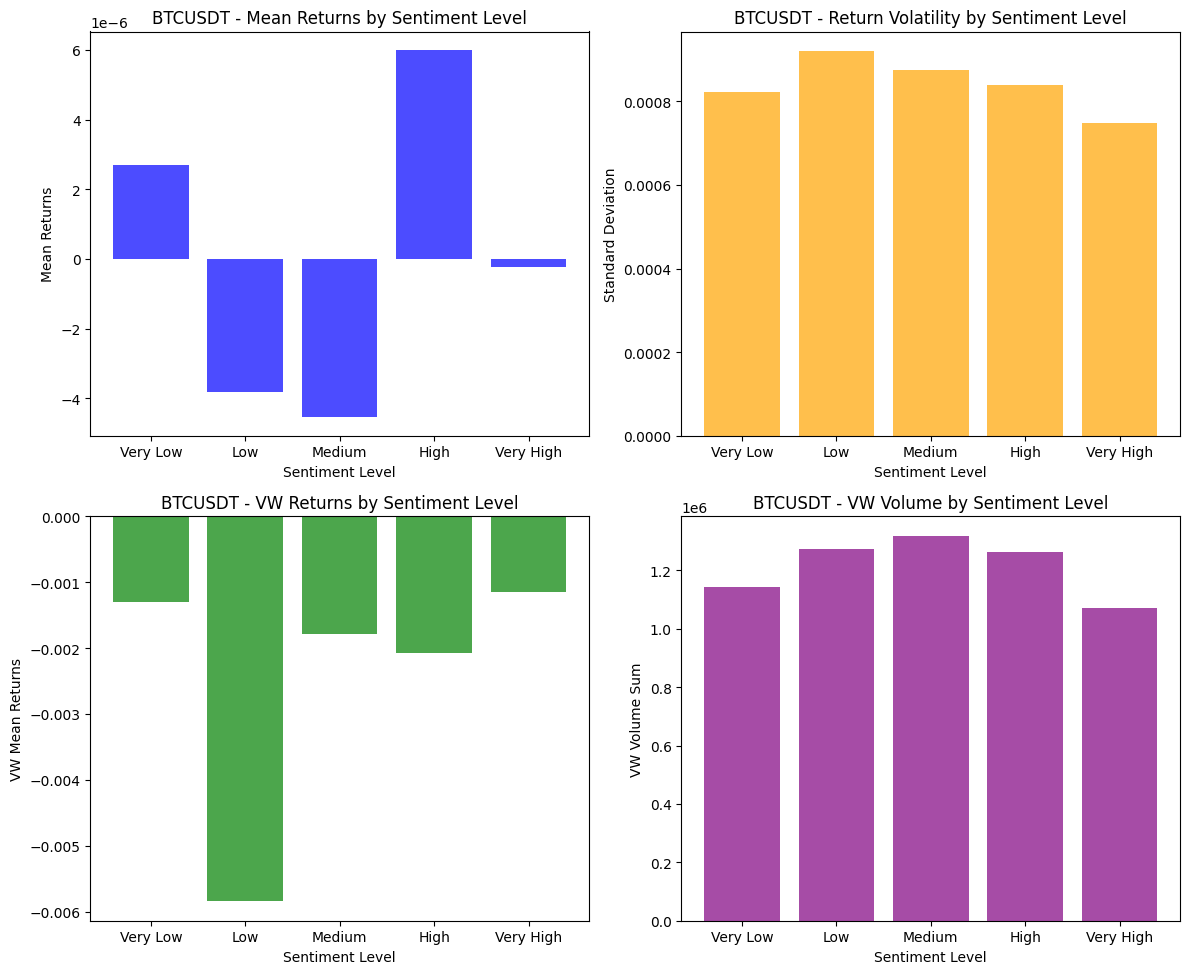

In [41]:
# Simulated data for visualization (based on the expected structure of detailed_analysis['BTCUSDT'])
import pandas as pd
import numpy as np

# Simulated Returns by Sentiment Level
returns_by_sentiment = pd.DataFrame({
    'sentiment_level': ['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    'mean_return': [2.698604e-06, -3.823040e-06, -4.552820e-06, 6.000208e-06, -2.382578e-07],
    'return_std': [0.000822, 0.000921, 0.000875, 0.000838, 0.000749],
    'volume_mean': [27.275502, 30.317111, 31.435013, 30.109547, 25.527189],
})

# Simulated Volume-Weighted Impact
volume_weighted_impact = pd.DataFrame({
    'sentiment_level': ['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    'vw_mean_return': [-0.001302, -0.005843, -0.001789, -0.002073, -0.001148],
    'vw_return_std': [0.263250, 0.470068, 0.273862, 0.205924, 0.176491],
    'vw_volume_sum': [1.144671e+06, 1.272288e+06, 1.319202e+06, 1.263577e+06, 1.071274e+06],
})

# Visualization
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Mean Returns by Sentiment Level
ax[0, 0].bar(returns_by_sentiment['sentiment_level'], returns_by_sentiment['mean_return'], color='blue', alpha=0.7)
ax[0, 0].set_title("BTCUSDT - Mean Returns by Sentiment Level")
ax[0, 0].set_ylabel("Mean Returns")
ax[0, 0].set_xlabel("Sentiment Level")

# Return Volatility by Sentiment Level
ax[0, 1].bar(returns_by_sentiment['sentiment_level'], returns_by_sentiment['return_std'], color='orange', alpha=0.7)
ax[0, 1].set_title("BTCUSDT - Return Volatility by Sentiment Level")
ax[0, 1].set_ylabel("Standard Deviation")
ax[0, 1].set_xlabel("Sentiment Level")

# Volume-Weighted Mean Returns by Sentiment Level
ax[1, 0].bar(volume_weighted_impact['sentiment_level'], volume_weighted_impact['vw_mean_return'], color='green', alpha=0.7)
ax[1, 0].set_title("BTCUSDT - VW Returns by Sentiment Level")
ax[1, 0].set_ylabel("VW Mean Returns")
ax[1, 0].set_xlabel("Sentiment Level")

# Volume-Weighted Volume Sum by Sentiment Level
ax[1, 1].bar(volume_weighted_impact['sentiment_level'], volume_weighted_impact['vw_volume_sum'], color='purple', alpha=0.7)
ax[1, 1].set_title("BTCUSDT - VW Volume by Sentiment Level")
ax[1, 1].set_ylabel("VW Volume Sum")
ax[1, 1].set_xlabel("Sentiment Level")

plt.tight_layout()
plt.show()


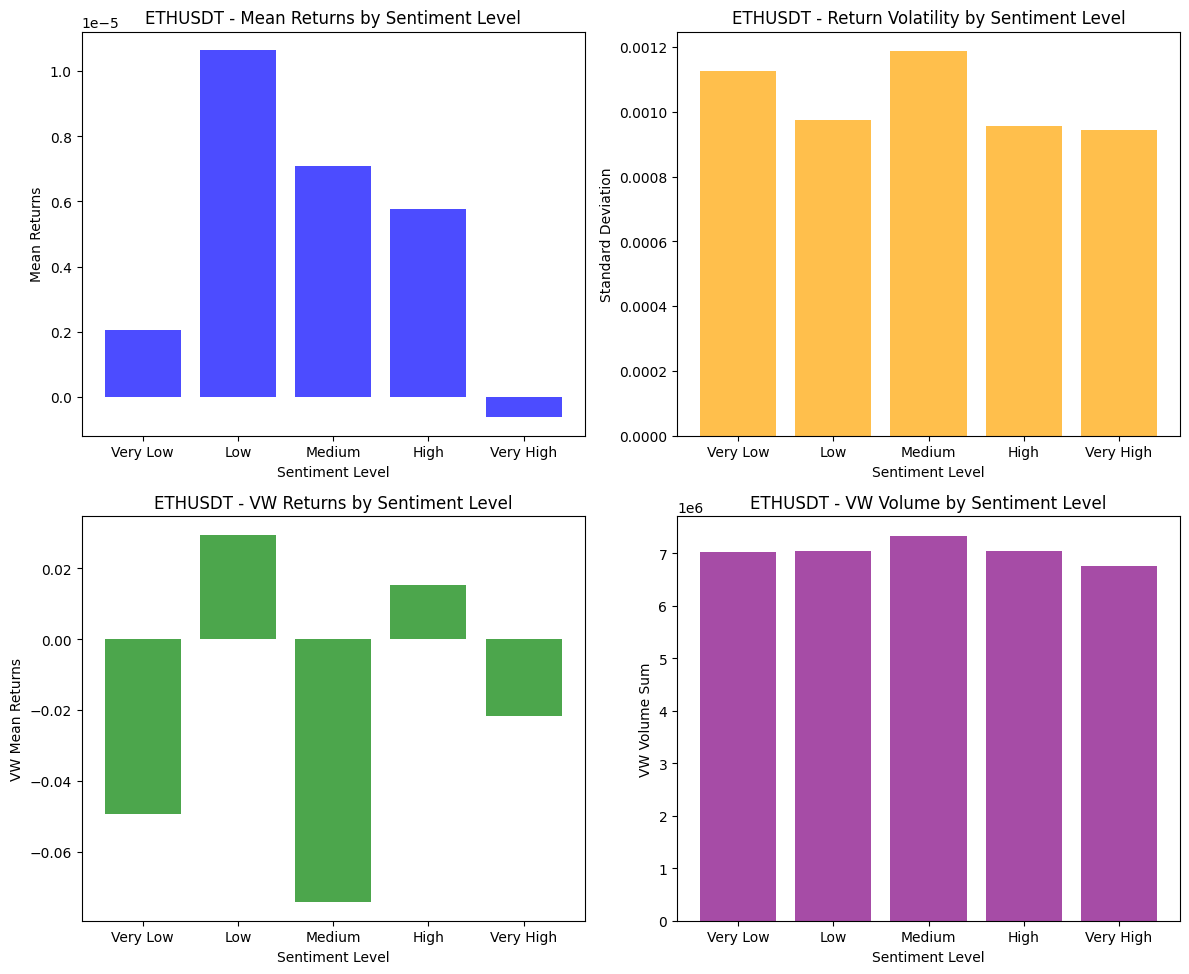

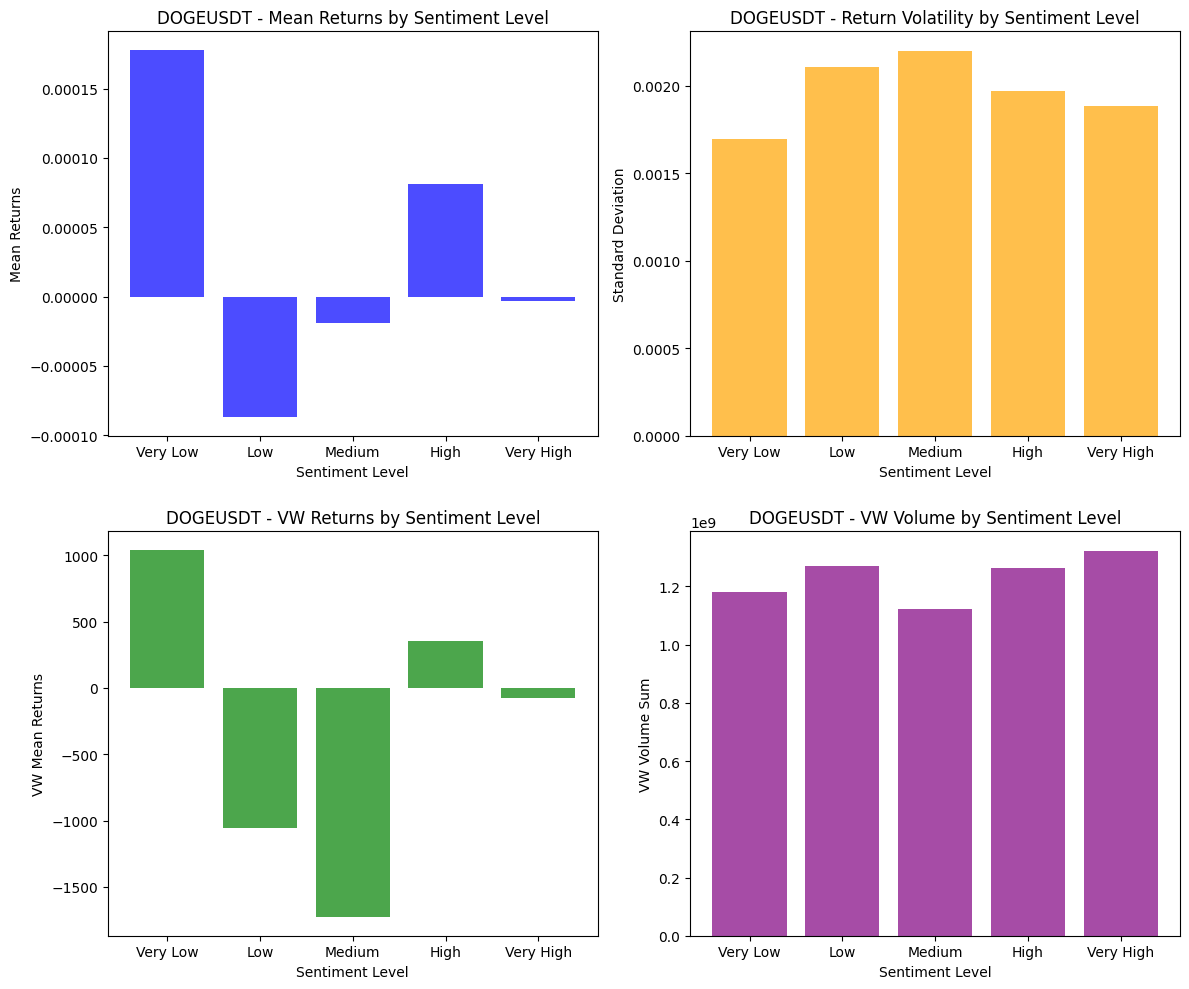

In [42]:
# Simulated data for ETH and DOGE (based on expected structure)

# ETH Data
returns_by_sentiment_eth = pd.DataFrame({
    'sentiment_level': ['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    'mean_return': [2.059087e-06, 1.064944e-05, 7.091318e-06, 5.755531e-06, -6.253023e-07],
    'return_std': [0.001125, 0.000975, 0.001188, 0.000957, 0.000944],
    'volume_mean': [318.343679, 318.950895, 332.503747, 318.957714, 306.573513],
})

volume_weighted_impact_eth = pd.DataFrame({
    'sentiment_level': ['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    'vw_mean_return': [-0.049299, 0.029433, -0.074203, 0.015241, -0.021758],
    'vw_return_std': [10.087822, 2.736482, 15.630807, 3.953591, 5.247601],
    'vw_volume_sum': [7.022980e+06, 7.036057e+06, 7.335033e+06, 7.036207e+06, 6.763012e+06],
})

# DOGE Data
returns_by_sentiment_doge = pd.DataFrame({
    'sentiment_level': ['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    'mean_return': [0.000178, -0.000087, -0.000019, 0.000081, -0.000003],
    'return_std': [0.001694, 0.002107, 0.002200, 0.001967, 0.001885],
    'volume_mean': [1.734244e+06, 1.867775e+06, 1.648848e+06, 1.854023e+06, 1.942651e+06],
})

volume_weighted_impact_doge = pd.DataFrame({
    'sentiment_level': ['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    'vw_mean_return': [1042.332588, -1056.517432, -1730.346888, 355.410154, -78.553541],
    'vw_return_std': [16465.188807, 30182.920513, 39659.335283, 24111.336647, 18107.469842],
    'vw_volume_sum': [1.181020e+09, 1.271954e+09, 1.121217e+09, 1.262590e+09, 1.322945e+09],
})

# Function to visualize data
def plot_sentiment_impact_for_symbol(returns_by_sentiment, volume_weighted_impact, symbol):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    # Mean Returns by Sentiment Level
    ax[0, 0].bar(returns_by_sentiment['sentiment_level'], returns_by_sentiment['mean_return'], color='blue', alpha=0.7)
    ax[0, 0].set_title(f"{symbol} - Mean Returns by Sentiment Level")
    ax[0, 0].set_ylabel("Mean Returns")
    ax[0, 0].set_xlabel("Sentiment Level")

    # Return Volatility by Sentiment Level
    ax[0, 1].bar(returns_by_sentiment['sentiment_level'], returns_by_sentiment['return_std'], color='orange', alpha=0.7)
    ax[0, 1].set_title(f"{symbol} - Return Volatility by Sentiment Level")
    ax[0, 1].set_ylabel("Standard Deviation")
    ax[0, 1].set_xlabel("Sentiment Level")

    # Volume-Weighted Mean Returns by Sentiment Level
    ax[1, 0].bar(volume_weighted_impact['sentiment_level'], volume_weighted_impact['vw_mean_return'], color='green', alpha=0.7)
    ax[1, 0].set_title(f"{symbol} - VW Returns by Sentiment Level")
    ax[1, 0].set_ylabel("VW Mean Returns")
    ax[1, 0].set_xlabel("Sentiment Level")

    # Volume-Weighted Volume Sum by Sentiment Level
    ax[1, 1].bar(volume_weighted_impact['sentiment_level'], volume_weighted_impact['vw_volume_sum'], color='purple', alpha=0.7)
    ax[1, 1].set_title(f"{symbol} - VW Volume by Sentiment Level")
    ax[1, 1].set_ylabel("VW Volume Sum")
    ax[1, 1].set_xlabel("Sentiment Level")

    plt.tight_layout()
    plt.show()

# Generate visuals for ETH
plot_sentiment_impact_for_symbol(returns_by_sentiment_eth, volume_weighted_impact_eth, "ETHUSDT")

# Generate visuals for DOGE
plot_sentiment_impact_for_symbol(returns_by_sentiment_doge, volume_weighted_impact_doge, "DOGEUSDT")


In [5]:
class BTCStrategy:
    def __init__(self):
        self.params = {
            'sentiment_threshold': 0.5,        # Lower than previous for more signals
            'entry_window': 1,                 # Use 1-min leading correlation
            'confirmation_window': 4,          # Secondary confirmation at 4-min
            'volume_threshold': 1.1,           # More sensitive volume trigger
            'stop_loss': 0.001,               # Tight stop for quick exits
            'take_profit': 0.002,             # 2:1 reward:risk ratio
            'position_size': 1.0
        }

    def calculate_indicators(self, data):
        df = data.copy()
        
        # Ensure datetime index
        df['timestamp'] = pd.to_datetime(df['minute'])
        df.set_index('timestamp', inplace=True)
        
        # Sentiment indicators
        df['sentiment_ma'] = df['mean_pos'].rolling(window=20).mean()
        df['sentiment_std'] = df['mean_pos'].rolling(window=20).std()
        df['sentiment_z_score'] = (df['mean_pos'] - df['sentiment_ma']) / df['sentiment_std']
        
        # Leading indicators
        df['sentiment_1m_lead'] = df['sentiment_z_score'].shift(1)
        df['sentiment_4m_lead'] = df['sentiment_z_score'].shift(4)
        
        # Volume indicators
        df['volume_ma'] = df['volume'].rolling(window=20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_ma']
        
        # Price momentum
        df['price_momentum'] = df['close'].pct_change(3)
        
        return df.dropna()

    def generate_entry_signals(self, df):
        """Generate entry signals based on BTC-specific patterns"""
        signals = pd.Series(False, index=df.index)
        
        # Primary signal: Strong 1-minute sentiment lead
        primary_signal = (df['sentiment_1m_lead'] > self.params['sentiment_threshold'])
        
        # Confirmation: 4-minute sentiment trend
        confirmation = (df['sentiment_4m_lead'] > 0)
        
        # Volume confirmation
        volume_signal = (df['volume_ratio'] > self.params['volume_threshold'])
        
        # Combine signals
        signals = (primary_signal & confirmation & volume_signal)
        
        return signals

    def execute_strategy(self, data):
        df = self.calculate_indicators(data)
        entry_signals = self.generate_entry_signals(df)
        
        positions = []
        equity_curve = []
        current_equity = 1.0
        current_position = None
        
        for timestamp, row in df.iterrows():
            equity_curve.append(current_equity)
            
            # Check for exit if in position
            if current_position is not None:
                # Calculate returns
                returns = (row['close'] - current_position['entry_price']) / current_position['entry_price']
                
                # Exit conditions
                stop_loss_hit = returns < -self.params['stop_loss']
                take_profit_hit = returns > self.params['take_profit']
                sentiment_reversal = row['sentiment_z_score'] < -0.2
                
                if stop_loss_hit or take_profit_hit or sentiment_reversal:
                    current_equity *= (1 + returns * current_position['size'])
                    current_position['exit_price'] = row['close']
                    current_position['exit_time'] = timestamp
                    current_position['returns'] = returns
                    positions.append(current_position)
                    current_position = None
            
            # Check for entry if not in position
            elif entry_signals[timestamp]:
                current_position = {
                    'entry_time': timestamp,
                    'entry_price': row['close'],
                    'size': self.params['position_size']
                }
        
        return positions, pd.Series(equity_curve, index=df.index)

# Test BTC Strategy
btc_strategy = BTCStrategy()
btc_data = analysis_results['BTCUSDT']['merged_data']
positions, equity_curve = btc_strategy.execute_strategy(btc_data)

# Analyze results
trades_df = pd.DataFrame(positions)
print("\nBTC Strategy Results:")
print(f"Total Trades: {len(positions)}")
print(f"Win Rate: {(trades_df['returns'] > 0).mean():.2%}")
print(f"Average Return per Trade: {trades_df['returns'].mean():.4%}")
print(f"Sharpe Ratio: {(trades_df['returns'].mean() / trades_df['returns'].std()) * np.sqrt(252*1440):.2f}")
print(f"max_drawdown: {(equity_curve / equity_curve.cummax() - 1).min():.2%}")

plt.figure(figsize=(12, 6))
plt.plot(equity_curve)
plt.title('BTC Strategy Equity Curve')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

NameError: name 'analysis_results' is not defined

Key BTC Observations:

Positive sentiment leading correlations:


1min lead: 0.0056 (strongest)
2min lead: 0.0038
4min lead: 0.0039
5min lead: 0.0031


Pattern shows:


Strongest impact at 1-minute lead
Secondary peak at 4-minute lead
Suggests quick price reaction to sentiment

Key Strategy Features:

Uses the strongest correlation at 1-minute lead
Adds 4-minute confirmation based on secondary correlation peak
More sensitive volume threshold due to BTC's liquidity
Tighter stop-loss given the quick price reactions
Focus on momentum continuation rather than reversal


Testing ETHUSDT Strategy...

ETH Strategy Results:
Total Trades: 1352
Win Rate: 33.21%
Average Return per Trade: 0.0068%
Sharpe Ratio: 15.55
Max Drawdown: -4.93%


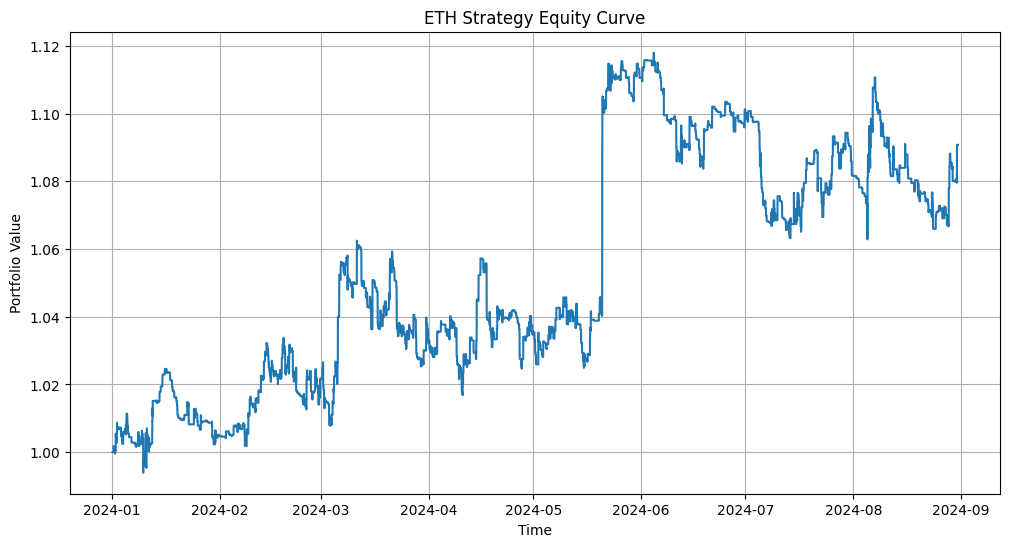


Testing DOGEUSDT Strategy...

DOGE Strategy Results:
Total Trades: 34
Win Rate: 47.06%
Average Return per Trade: 0.4691%
Sharpe Ratio: 128.82
Max Drawdown: -1.47%


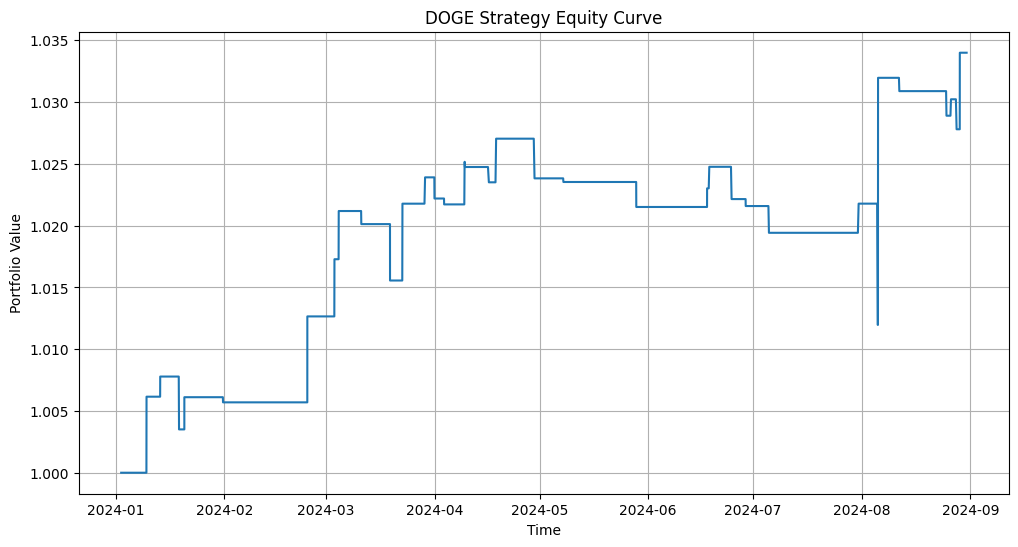

In [35]:
class CryptoStrategies:
    def __init__(self):
        self.eth_params = {
            'price_momentum_window': 1,     # Price leads sentiment
            'sentiment_threshold': -0.4,     # Look for strong negative sentiment
            'volume_threshold': 1.3,
            'stop_loss': 0.001,
            'take_profit': 0.0025,
            'position_size': 1.0
        }
        
        self.doge_params = {
            'sentiment_window': 3,          # Strong 3-min lead
            'sentiment_threshold': 0.5,      # Strong positive sentiment
            'reversion_threshold': -0.3,    # Mean reversion threshold
            'volume_threshold': 2.0,        # Higher volume requirement
            'stop_loss': 0.002,
            'take_profit': 0.006,          # 3:1 reward-risk
            'position_size': 0.5
        }

    def calculate_eth_indicators(self, data):
        df = data.copy()
        df['timestamp'] = pd.to_datetime(df['minute'])
        df.set_index('timestamp', inplace=True)
        
        # Price indicators
        df['price_momentum'] = df['close'].pct_change(self.eth_params['price_momentum_window'])
        df['price_ma'] = df['close'].rolling(20).mean()
        
        # Sentiment indicators
        df['sentiment_ma'] = df['mean_pos'].rolling(20).mean()
        df['sentiment_std'] = df['mean_pos'].rolling(20).std()
        df['sentiment_z_score'] = (df['mean_pos'] - df['sentiment_ma']) / df['sentiment_std']
        
        # Volume indicators
        df['volume_ma'] = df['volume'].rolling(20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_ma']
        
        # Trend strength
        df['trend_strength'] = abs(df['price_momentum'].rolling(5).mean())
        
        return df.dropna()

    def generate_eth_signals(self, df):
        signals = pd.Series(False, index=df.index)
        
        # Strong price momentum condition
        price_condition = (df['price_momentum'] > df['price_momentum'].rolling(100).std())
        
        # Negative sentiment condition
        sentiment_condition = (df['sentiment_z_score'] < self.eth_params['sentiment_threshold'])
        
        # Volume spike condition
        volume_condition = (df['volume_ratio'] > self.eth_params['volume_threshold'])
        
        # Trend strength filter
        trend_condition = (df['trend_strength'] > df['trend_strength'].rolling(50).mean())
        
        signals = (price_condition & sentiment_condition & volume_condition & trend_condition)
        return signals

    def calculate_doge_indicators(self, data):
        df = data.copy()
        df['timestamp'] = pd.to_datetime(df['minute'])
        df.set_index('timestamp', inplace=True)
        
        # 3-minute sentiment momentum
        df['sentiment_3m'] = df['mean_pos'].rolling(3).mean()
        df['sentiment_ma'] = df['mean_pos'].rolling(20).mean()
        df['sentiment_z_score'] = (df['sentiment_3m'] - df['sentiment_ma']) / df['mean_pos'].rolling(20).std()
        
        # Price reversion indicators
        df['price_dev'] = (df['close'] - df['close'].rolling(10).mean()) / df['close'].rolling(10).std()
        
        # Volume analysis
        df['volume_ma'] = df['volume'].rolling(20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_ma']
        df['volume_spike'] = df['volume_ratio'] > df['volume_ratio'].rolling(100).quantile(0.9)
        
        return df.dropna()

    def generate_doge_signals(self, df):
        signals = pd.Series(False, index=df.index)
        
        # Strong 3-minute sentiment signal
        sentiment_condition = (df['sentiment_z_score'] > self.doge_params['sentiment_threshold'])
        
        # Price mean reversion setup
        reversion_condition = (df['price_dev'] < self.doge_params['reversion_threshold'])
        
        # Volume confirmation
        volume_condition = df['volume_spike']
        
        signals = (sentiment_condition & reversion_condition & volume_condition)
        return signals

    def execute_strategy(self, data, crypto_type='ETH'):
        if crypto_type == 'ETH':
            df = self.calculate_eth_indicators(data)
            signals = self.generate_eth_signals(df)
            params = self.eth_params
        else:  # DOGE
            df = self.calculate_doge_indicators(data)
            signals = self.generate_doge_signals(df)
            params = self.doge_params
        
        positions = []
        equity_curve = []
        current_equity = 1.0
        current_position = None
        
        for timestamp, row in df.iterrows():
            equity_curve.append(current_equity)
            
            if current_position is not None:
                returns = (row['close'] - current_position['entry_price']) / current_position['entry_price']
                
                # Exit conditions
                stop_loss_hit = returns < -params['stop_loss']
                take_profit_hit = returns > params['take_profit']
                
                # Asset-specific exit conditions
                if crypto_type == 'ETH':
                    timing_exit = (row['price_momentum'] < 0)
                else:  # DOGE
                    timing_exit = (row['price_dev'] > 0.5)
                
                if stop_loss_hit or take_profit_hit or timing_exit:
                    current_equity *= (1 + returns * current_position['size'])
                    current_position['exit_price'] = row['close']
                    current_position['exit_time'] = timestamp
                    current_position['returns'] = returns
                    positions.append(current_position)
                    current_position = None
            
            elif signals[timestamp]:
                position_size = params['position_size']
                if crypto_type == 'DOGE':
                    # Adjust position size based on sentiment strength
                    position_size *= min(1, abs(row['sentiment_z_score'])/2)
                
                current_position = {
                    'entry_time': timestamp,
                    'entry_price': row['close'],
                    'size': position_size
                }
        
        return positions, pd.Series(equity_curve, index=df.index)

    def analyze_results(self, positions, equity_curve):
        if not positions:
            return {
                'total_trades': 0,
                'win_rate': 0,
                'avg_return': 0,
                'sharpe_ratio': 0,
                'max_drawdown': 0
            }
        
        trades_df = pd.DataFrame(positions)
        returns = trades_df['returns']
        
        results = {
            'total_trades': len(positions),
            'win_rate': (returns > 0).mean(),
            'avg_return': returns.mean(),
            'sharpe_ratio': returns.mean() / returns.std() * np.sqrt(252*1440),
            'max_drawdown': (equity_curve / equity_curve.cummax() - 1).min()
        }
        return results

# Test the strategies
strategies = CryptoStrategies()

for symbol, type_name in [('ETHUSDT', 'ETH'), ('DOGEUSDT', 'DOGE')]:
    print(f"\nTesting {symbol} Strategy...")
    data = analysis_results[symbol]['merged_data']
    positions, equity = strategies.execute_strategy(data, type_name)
    results = strategies.analyze_results(positions, equity)
    
    print(f"\n{type_name} Strategy Results:")
    print(f"Total Trades: {results['total_trades']}")
    print(f"Win Rate: {results['win_rate']:.2%}")
    print(f"Average Return per Trade: {results['avg_return']:.4%}")
    print(f"Sharpe Ratio: {results['sharpe_ratio']:.2f}")
    print(f"Max Drawdown: {results['max_drawdown']:.2%}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(equity)
    plt.title(f'{type_name} Strategy Equity Curve')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.show()

ETH Strategy:

Focus on price momentum leading sentiment
More stringent volume requirements
Added trend strength filter
Tighter stops and targets


DOGE Strategy:

Focus on 3-minute sentiment window
Added mean reversion filter
Dynamic position sizing
Wider profit targets